Simple map reduce function for testing purposes. 

In [1]:
from collections import defaultdict

def sort(mapped_pairs):
    
    grouped_values = defaultdict(list)
    
    for output in mapped_pairs:
        for k, v in output:
            grouped_values[k].append(v)
        
    keys = list()
    groups = list()
    for key, group in grouped_values.items():
        keys.append(key)
        groups.append(group)
    
    return keys, groups

#def shuffle(task, inputs, n=3):
#    
#    nodes = defaultdict(list)
#    for 
    

def map_reduce(data, mapper, reducer, combiner=None):
    
    mapped_pairs = map(mapper, data)    
    groups_list = sort(mapped_pairs)
    
    if combiner is not None:
        # This is like a reducer, but it might only recieve
        # some of the values for a key. To simulate that
        # important difference we need multiple nodes.
        mapped_pairs = map(combiner, *groups_list)
        groups_list = sort(mapped_pairs)
        
    reduced_pairs = map(reducer, *groups_list)
    
    results = list()
    for reducer_output in reduced_pairs:
        for k, v in reducer_output:
            results.append((k, v))
    
    return list(results)

Example usage.

In [2]:
def example_map(item):    
    yield item, 1
        
def example_reduce(key, values):
    yield key, sum(values)
        
map_reduce("abacaba", example_map, example_reduce, combiner=example_reduce)

[('a', 4), ('b', 2), ('c', 1)]

### Question 1

In [3]:
import re

data = [
    "https://www.ucd.ie/1,      453KB,      21/09/2019",
    "https://hadoop.apache.ord/1,      5.1KB,      22/09/2019",
    "https://www.ucd.ie/2,      300KB,      23/09/2019"
]

def q1_map(item):
    pattern = r"https:\/\/([^\/]*)\/.*,\s*(\d+).*,.*"
    domain, byte_count = re.match(pattern, item).groups()
    yield domain, int(byte_count)
        
def q1_reduce(key, values):
    yield key, sum(values)
        
map_reduce(data, q1_map, q1_reduce)

[('www.ucd.ie', 753), ('hadoop.apache.ord', 5)]

### Question 2

Matrix multiplication! Go...

Attempt 1.<br>

Terribly inefficient in that it requires the data to be the cartesian product of the input cells with indices...

This means it requires `O(N*M*N*M)` space!!! 

In [4]:
# [1 2; 3 4] * [5 6; 7 8] = [19 22; 43 50]

data = [
    ((1, 1), 1, (1, 1), 5),
    ((1, 2), 2, (1, 1), 5),  # Ignored
    ((2, 1), 3, (1, 1), 5),  
    ((2, 2), 4, (1, 1), 5),  # Ignored
    ((1, 1), 1, (1, 2), 6),  
    ((1, 2), 2, (1, 2), 6),  # Ignored
    ((2, 1), 3, (1, 2), 6),
    ((2, 2), 4, (1, 2), 6),  # Ignored
    ((1, 1), 1, (2, 1), 7),  # Ignored
    ((1, 2), 2, (2, 1), 7), 
    ((2, 1), 3, (2, 1), 7),  # Ignored
    ((2, 2), 4, (2, 1), 7),
    ((1, 1), 1, (2, 2), 8),  # Ignored
    ((1, 2), 2, (2, 2), 8),
    ((2, 1), 3, (2, 2), 8),  # Ignored
    ((2, 2), 4, (2, 2), 8),
]

def awkward_map(item):
    (i, n), Ain, (m, j), Bmj = item
    if n == m:
        yield (i, j), Ain*Bmj
            
def awkward_reduce(key, values):
    yield key, sum(values)
    
map_reduce(data, awkward_map, awkward_reduce)

[((1, 1), 19), ((2, 1), 43), ((1, 2), 22), ((2, 2), 50)]

That was terrible. This one is a lot better, it's loosely based on an articly by Geeks for Geeks.

In [5]:
# A: 1 2; 3 4
# B: 5 6; 7 8

data = [
    ("a", (1, 1), 1),
    ("a", (1, 2), 2),
    ("a", (2, 1), 3),
    ("a", (2, 2), 4),
    ("b", (1, 1), 5),
    ("b", (1, 2), 6),
    ("b", (2, 1), 7),
    ("b", (2, 2), 8),
]

N = 2

def matmul_map(item):
    
    source, (n, m), value = item
    
    if source == "a":
        i = n
        k = m
        for j in range(1, N+1):
            yield (i, j), (k, value)

    else:
        k = n
        j = m
        for i in range(1, N+1):
            yield (i, j), (k, value) 
                
def matmul_reduce(key, values):
      
    terms = [1]*N

    for k, factor in values:

        terms[k-1] *= factor

    yield key, sum(terms)
    
map_reduce(data, matmul_map, matmul_reduce)

[((1, 1), 19), ((1, 2), 22), ((2, 1), 43), ((2, 2), 50)]

That does requires the allocation of an array of length N on each reducer node.

### Question 3

k-means.

One iteration of this means mapping a series of points to the nearest centroid, and then recomputing the centroid.

First, lets write a non-mapreduce based one for testing and visualization.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def kmeans(points):
    
    N = len(points)
    X = [x for x, y in points]
    Y = [y for x, y in points]
    
    colors = "rgbmy"
    k = len(colors)
    centroids = np.zeros([k, 2])

    # Initialize centroids to a ring around the center
    theta = np.linspace(0, 1, k, endpoint=False)
    for i in range(k):
        centroids[i][0] = 0.5 + 0.2*np.cos(2*np.pi*theta[i])
        centroids[i][1] = 0.5 + 0.2*np.sin(2*np.pi*theta[i])

    counts = defaultdict(int)
    point_groups = np.zeros(N, int)

    def plot():

        plt.figure()

        for i, (x, y) in enumerate(centroids):
            c = colors[i]
            plt.plot(x, y, "o", c=c, markersize=20, alpha=0.4)
        
        C = list(map(lambda n: colors[n], point_groups))
        plt.scatter(X, Y, c=C)

    def reassign():

        changes = 0

        for i in range(N):

            x, y = points[i]
            old_group = point_groups[i]

            def key(i):
                cx, cy = centroids[i]
                return (x-cx)**2 + (y-cy)**2

            new_group = min(range(k), key=key)
            if new_group != old_group:
                point_groups[i] = new_group
                changes += 1

        return changes
    
    def update_centroids():

        for group in range(k):
            counts[group] = 0
            centroids[group] = [0,0]

        for group, (x, y) in zip(point_groups, points):
            counts[group] += 1
            centroids[group][0] += x
            centroids[group][1] += y

        for i in range(len(centroids)):
            if counts[i] > 0:
                centroids[i][0] /= counts[i]
                centroids[i][1] /= counts[i]

    changes = 1
    iterations = 0
    while changes > 0 and iterations < 20:

        changes = reassign()
        update_centroids()
        # plot()

        iterations += 1

    print("Iterations:", iterations)
    plot()

Iterations: 3


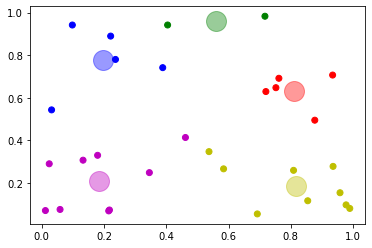

In [10]:
kmeans(np.random.random([30,2]))

Note: the stability of the algorithm is tied to the starting points of the centroids - as long as they are stable, the result seems to be stable for any order of points. This makes sense - the "reassign" action acts on each point independantly, and the "update_centroids" involves taking the average which is commutative.

Right... about mapreduce. We want the number of points to be scalable. Maybe the number of groups too.
<br>(Let `N` be the number of points, and `K` the number of groups)

First version, based off a paper:
<br>https://sites.cs.ucsb.edu/~veronika/MAE/parallelkmeansmapreduce_zhao.pdf

This is **not** scalable in k. It is scalable in N though, which is cool.
<br>Each iteration is a separate mapreduce step.

In [68]:
def kmeans_map(centroids):
    
    def mapper(item):

        x, y = item

        def distance(i):
            cx, cy = centroids[i]
            return (x - cx)**2 + (y - cy)**2

        closest_k = min(range(k), key=distance)
        yield closest_k, (x, y)
            
    return mapper
    
def kmeans_reduce(key, values):
       
    cx, cy = 0, 0
    count = 0

    for x, y in values:
        cx += x
        cy += y
        count += 1

    if count > 0:
        cx /= count
        cy /= count

    yield key, (cx, cy)
    
N, k = 100, 5
data = np.random.random([N,2])

centroids = np.random.random([k, 2])

map_reduce(data, kmeans_map(centroids), kmeans_reduce)

[(3, (0.28885358497995345, 0.14715834982518367)),
 (2, (0.674433537193325, 0.8592348676868705)),
 (4, (0.5513724087685482, 0.5088615533340051)),
 (0, (0.8243732674195053, 0.16751168626297255)),
 (1, (0.12922879905864107, 0.7471216478907183))]

In [69]:
def plot(points, centroids):
    
    N = len(points)
    k = len(centroids)
    
    points_k = np.zeros(N, int)
    for i, (x, y) in enumerate(points):
        
        def distance(i):
            cx, cy = centroids[i]
            return (x - cx)**2 + (y - cy)**2
        
        points_k[i] = min(range(k), key=distance)
        
    colors = "rgbmy"
    plt.figure()
        
    for i, (x, y) in enumerate(centroids):
        c = colors[i]
        plt.plot(x, y, "o", c=c, markersize=20, alpha=0.4)

    X = [x for x, y in points]
    Y = [y for x, y in points]
    C = list(map(lambda n: colors[n], points_k))
    plt.scatter(X, Y, c=C)        

Example with picture, and iteration.

Iterations: 7


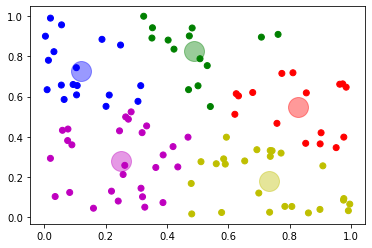

In [75]:
def kmeans_mapreduce(get_map, reducer, combiner=None):
    
    N, k = 100, 5
    points = np.random.random([N,2])

    centroids = list()

    theta = np.linspace(0, 1, k, endpoint=False)
    for i in range(k):
        cx = 0.5 + 0.2*np.cos(2*np.pi*theta[i])
        cy = 0.5 + 0.2*np.sin(2*np.pi*theta[i])
        centroids.append((cx, cy))

    for i in range(20):

        result = map_reduce(points, get_map(centroids), reducer, combiner)

        any_changes = False

        for ki, (x, y) in result:
            if centroids[ki] != (x, y):
                any_changes = True
                centroids[ki] = (x, y)

        if not any_changes:
            break

    print("Iterations:", i)
    plot(points, centroids)
    
kmeans_mapreduce(kmeans_map, kmeans_reduce)

V2 with combiner.

Iterations: 8


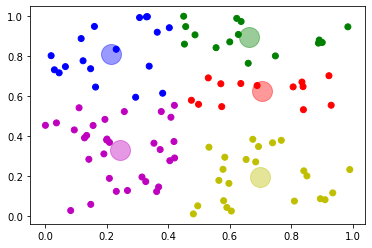

In [78]:
def kmeans_combine(key, values):
    
    cx = 0
    cy = 0
    count = 0

    for x, y in values:
        cx += x
        cy += y
        count += 1

    if count > 0:
        cx /= count
        cy /= count

    yield key, (cx, cy, count)
    
def kmeans_reduce2(key, values):
       
    cx, cy = 0, 0
    count = 0

    for x, y, subcount in values:
        cx += x * subcount
        cy += y * subcount
        count += subcount

    if count > 0:
        cx /= count
        cy /= count

    yield key, (cx, cy)
    
kmeans_mapreduce(kmeans_map, kmeans_reduce2, kmeans_combine)

Appendix: Keeping track of iterations by writing back to data. This is a **terrible** idea.

8


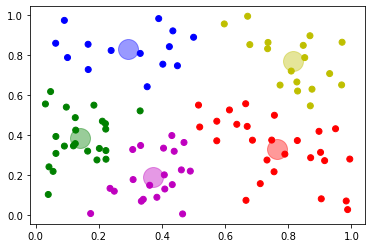

In [79]:
def get_map(centroids):
    
    def my_map(item):

        x, y, key, previous_k = item

        def distance(i):
            cx, cy = centroids[i]
            return (x - cx)**2 + (y - cy)**2

        closest_k = min(range(k), key=distance)
        changed = closest_k != previous_k

        # writeback
        data[key][3] = closest_k

        yield closest_k, (x, y, changed)
            
    return my_map
        
def my_reduce(key, values):
    
    new_centroid = [0,0]
    count = 0
    any_changes = False

    for x, y, changed in values:

        new_centroid[0] += x
        new_centroid[1] += y
        count += 1
        any_changes |= changed

    if count > 0:
        new_centroid[0] /= count
        new_centroid[1] /= count

    yield key, (new_centroid, any_changes)
    
########
# Test #
########
    
N, k = 100, 5
points = np.random.random([N,2])
data = [[x, y, i, 0] for i, (x, y) in enumerate(points)]

centroids = np.zeros([k,2])

theta = np.linspace(0, 1, k, endpoint=False)
for i in range(k):
    centroids[i][0] = 0.5 + 0.2*np.cos(2*np.pi*theta[i])
    centroids[i][1] = 0.5 + 0.2*np.sin(2*np.pi*theta[i])

centroids = np.random.random([k, 2])

for i in range(50):
    
    result = map_reduce(data, get_map(centroids), my_reduce)
    
    any_changes = False
    
    for key, (centroid, changes) in result:
        centroids[key] = centroid
        any_changes |= changes

    if not any_changes:
        break

print(i)
plot(points, centroids)